# How to use GPyTorch to build a Gaussian process regression model

This notebook illustrates how to use [GPyTorch](https://gpytorch.ai/) to build a GPR model. GPyTorch is built on top of PyTorch, and it exploits the optimization functions, such as gradient descent, that can be used to train the hyperparameters. By using PyTorch tensors, it also supports GPU acceleration.

## Start from some toy data

We sample some data points from the function $y = x\sin(x)$ in the range $x \in [0, 4\pi]$, and we add some Gaussian noise with zero mean and variance equal to $1$.

In [1]:
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

def toy_function(x):
    return x*torch.sin(x)

x = torch.linspace(0, 4*np.pi, 100)
y_true = toy_function(x)

n_train = 20
x_train = torch.linspace(0.5*torch.pi, 3.5*torch.pi, n_train)
torch.manual_seed(54)
noise = torch.normal(0, 1, size=(n_train,))
y_train = toy_function(x_train) + noise

In [2]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# move data to the gpu
x = x.to(device)
x_train = x_train.to(device)
y_train = y_train.to(device)

cpu


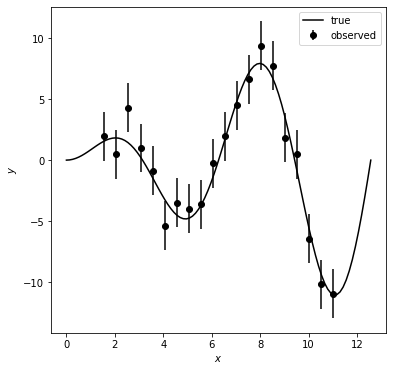

In [3]:
def plot_data(x, y_true, x_train, y_train, filename=''):
    fig, ax = plt.subplots(figsize=(6,6))
    
    ax.plot(x, y_true, c='k', alpha=1., ls='-', label='true')
    ax.errorbar(x_train, y_train, 2., c='k', fmt='o', label='observed')

    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.legend()
    
    if filename != '':
        fig.savefig(filename, transparent=False, dpi=600, bbox_inches='tight')    
    
    plt.show()

plot_data(x.cpu().numpy(), y_true.cpu().numpy(), x_train.cpu().numpy(), y_train.cpu().numpy())

## Create the class for our GP model

As in PyTorch, we need to create a class that inherits from the general ExactGP model. We need also to include a function ```forward(self, x)``` which prescribes the operations that we need to carry out when we apply the model on some inputs:
```y = model(x)```.

In [4]:
! pip install gpytorch

import torch
import gpytorch
from gpytorch.distributions import MultivariateNormal

# create a class from the ExactGP template
class ModelGP(gpytorch.models.ExactGP):
    
    # We need to provide:
    # - the training input and output (X_train, y_train)
    # - the likelihood
    # - the mean function
    # - the kernel function
    def __init__(self, X_train, y_train, likelihood, mean, kernel):
        super().__init__(X_train, y_train, likelihood)
        
        # we store the mean and kernel functions as attributes
        self.mean_module = mean
        self.covar_module = kernel
    
    # As for PyTorch, we need to define a forward function which 
    # transforms the input of the model
    def forward(self, x):
        mean_x = self.mean_module(x)
        kernel_x = self.covar_module(x)
        # the forward function computes the multivariate normal
        # given the mean and the kernel
        return MultivariateNormal(mean_x, kernel_x)


## Comparison with a simple neural network in PyTorch

As a comparison, this is how a PyTorch neural network is built:

```python
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First hidden layer
        self.relu = nn.ReLU()                          # Activation function
        self.fc2 = nn.Linear(hidden_size, hidden_size) # Second hidden layer
        self.fc3 = nn.Linear(hidden_size, output_size) # Output layer
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out
```


In [5]:
from gpytorch.means import ZeroMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood

mean = ZeroMean() # zero mean on the prior

# The kernel is the RBF kernel with a scale parameter
kernel = ScaleKernel(RBFKernel()) 

# We set a Gaussian learnable noise
likelihood = GaussianLikelihood()
likelihood = likelihood.to(device)

# Create the model
model = ModelGP(x_train, y_train, likelihood, mean, kernel)
model = model.to(device)


In [6]:
# no_grad is used to avoid the computation of 
# the gradient for optimization
with torch.no_grad():
    output = model(x_train)

# check the mean and stddev of the prior
print(output)
print(output.mean)
print(output.stddev)



MultivariateNormal(loc: torch.Size([20]))
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.8326, 0.8326, 0.8326, 0.8326, 0.8326, 0.8326, 0.8326, 0.8326, 0.8326,
        0.8326, 0.8326, 0.8326, 0.8326, 0.8326, 0.8326, 0.8326, 0.8326, 0.8326,
        0.8326, 0.8326])


In [7]:
# we put the model in train(), to find the optimal parameters
model.train()
model.likelihood.train()

# the optimizer is taken straight from PyTorch
optimizer = torch.optim.Adam(model.parameters(), lr=.1)

# as loss function, we use the log marginal likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

n_iterations = 200
for i in range(n_iterations):
    optimizer.zero_grad() # set the gradient to zero
    output = model(x_train) # compute the output of the model
    loss = -mll(output, y_train) # compare the output with the training data
    loss.backward() # compute backward propagation on the noise and 
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, n_iterations, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/200 - Loss: 7.613   lengthscale: 0.693   noise: 0.693
Iter 2/200 - Loss: 7.112   lengthscale: 0.744   noise: 0.744
Iter 3/200 - Loss: 6.685   lengthscale: 0.797   noise: 0.798
Iter 4/200 - Loss: 6.321   lengthscale: 0.849   noise: 0.853
Iter 5/200 - Loss: 6.011   lengthscale: 0.899   noise: 0.911
Iter 6/200 - Loss: 5.744   lengthscale: 0.945   noise: 0.969
Iter 7/200 - Loss: 5.512   lengthscale: 0.983   noise: 1.030
Iter 8/200 - Loss: 5.307   lengthscale: 1.013   noise: 1.091
Iter 9/200 - Loss: 5.121   lengthscale: 1.034   noise: 1.153
Iter 10/200 - Loss: 4.950   lengthscale: 1.045   noise: 1.215
Iter 11/200 - Loss: 4.794   lengthscale: 1.049   noise: 1.278
Iter 12/200 - Loss: 4.651   lengthscale: 1.046   noise: 1.340
Iter 13/200 - Loss: 4.520   lengthscale: 1.038   noise: 1.403
Iter 14/200 - Loss: 4.400   lengthscale: 1.025   noise: 1.465
Iter 15/200 - Loss: 4.293   lengthscale: 1.011   noise: 1.526
Iter 16/200 - Loss: 4.195   lengthscale: 0.994   noise: 1.586
Iter 17/200 - Los

/opt/anaconda3/envs/env_ml2/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/env_ml2/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/env_ml2/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


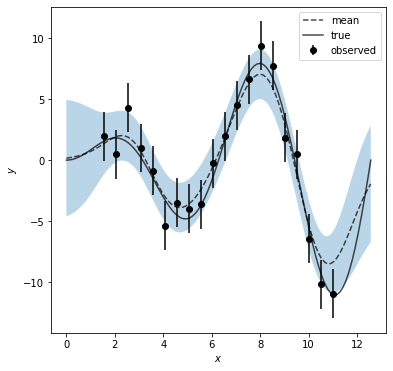

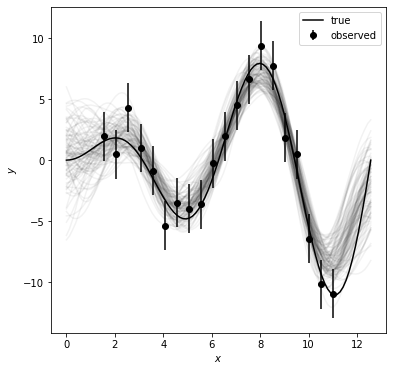

In [8]:
def plot_prediction_bounds(x, y_true, y_mean, y_bounds, x_train, y_train, filename=''):
    fig, ax = plt.subplots(figsize=(6,6))
    
    ax.plot(x, y_mean, c='k', alpha=.7, ls='--', label='mean')
    ax.plot(x, y_true, c='k', alpha=.7, ls='-', label='true')
    ax.fill_between(x, y_bounds[0], y_bounds[1], alpha=0.3)
    ax.errorbar(x_train, y_train, 2., c='k', fmt='o', label='observed')

    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.legend()
    
    plt.show()

def plot_prediction_samples(x, y_true, y_samples, x_train, y_train, filename=''):
    fig, ax = plt.subplots(figsize=(6,6))
    
    for i, y in enumerate(y_samples):
        ax.plot(x, y, c='k', alpha=.05, ls='-')

    ax.plot(x, y_true, c='k', alpha=1., ls='-', label='true')
    ax.errorbar(x_train, y_train, 2., c='k', fmt='o', label='observed')

    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.legend()
    
    plt.show()

# we switch to the predictive posterior
model.eval()
model.likelihood.eval()

with torch.no_grad():
    # get the predictive posterior
    prediction = model(x)
    # sample from the predictive posterior
    y_samples = prediction.sample(torch.Size([100])).cpu().numpy()
    # get the mean
    y_pred = prediction.mean.cpu().numpy()
    # get the confidence interval
    y_low, y_up = prediction.confidence_region()

plot_prediction_bounds(x.cpu().numpy(), y_true.cpu().numpy(), y_pred, [y_low.cpu().numpy(), y_up.cpu().numpy()], 
                       x_train.cpu().numpy(), y_train.cpu().numpy())
plot_prediction_samples(x.cpu().numpy(), y_true.cpu().numpy(), y_samples, 
                        x_train.cpu().numpy(), y_train.cpu().numpy())


## Known noise

What if we already know the noise of the measurements, for example if we have the uncertainty of the equipment?
We can view it as a fixed, non-trainable parameter.


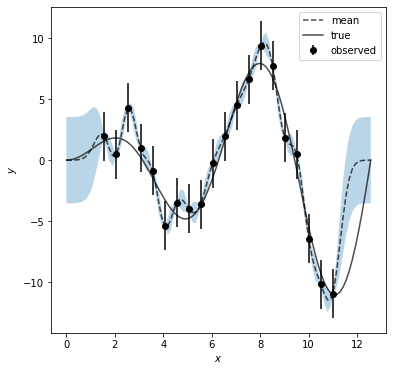

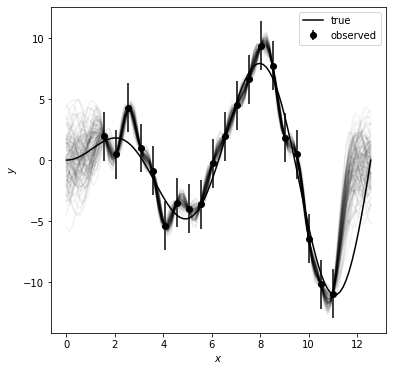

In [9]:
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood

mean = ZeroMean()
kernel = ScaleKernel(RBFKernel()) 

# We set a fixed Gaussian noise
noise = 1e-3*torch.ones(n_train)
likelihood = FixedNoiseGaussianLikelihood(noise)
likelihood = likelihood.to(device)

# Create the model
model = ModelGP(x_train, y_train, likelihood, mean, kernel)
model = model.to(device)

model.train()
model.likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

n_iterations = 100
for i in range(n_iterations):
    optimizer.zero_grad() # set the gradient to zero
    output = model(x_train) # compute the output of the model
    loss = -mll(output, y_train) # compare the output with the training data
    loss.backward() # compute backward propagation on the noise and 
    optimizer.step()

model.eval()
model.likelihood.eval()

with torch.no_grad():
    prediction = model(x)
    y_samples = prediction.sample(torch.Size([100])).cpu().numpy()
    y_pred = prediction.mean.cpu().numpy()
    y_low, y_up = prediction.confidence_region()

plot_prediction_bounds(x.cpu().numpy(), y_true.cpu().numpy(), y_pred, [y_low.cpu().numpy(), y_up.cpu().numpy()], 
                       x_train.cpu().numpy(), y_train.cpu().numpy())
plot_prediction_samples(x.cpu().numpy(), y_true.cpu().numpy(), y_samples, 
                        x_train.cpu().numpy(), y_train.cpu().numpy())

## Different kernels

The choice of the kernel controls the type of model we are using.

/opt/anaconda3/envs/env_ml2/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


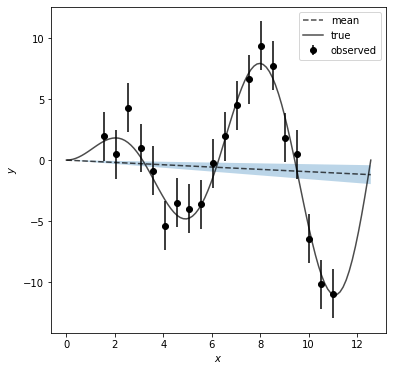

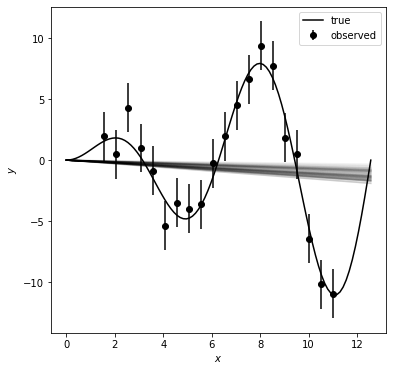

In [10]:
from gpytorch.constraints import Interval
from gpytorch.kernels import LinearKernel, PolynomialKernel, CosineKernel, MaternKernel, ConstantKernel

# change the kernel
kernel = ScaleKernel(LinearKernel()) 
# kernel = ScaleKernel(PolynomialKernel(2)) 
# kernel = ScaleKernel(CosineKernel())

period_cst = Interval(0, 4*np.pi)
# kernel = ScaleKernel(CosineKernel(period_length_constraint=period_cst)) 
# kernel = ScaleKernel(LinearKernel() * CosineKernel(period_length_constraint=period_cst))
# kernel = ScaleKernel(LinearKernel() * CosineKernel()) 

mean = ZeroMean()

noise = 1.*torch.ones(n_train)
likelihood = FixedNoiseGaussianLikelihood(noise)

model = ModelGP(x_train, y_train, likelihood, mean, kernel)
model = model.to(device)
likelihood = likelihood.to(device)

model.train()
model.likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

n_iterations = 100
for i in range(n_iterations):
    optimizer.zero_grad() # set the gradient to zero
    output = model(x_train) # compute the output of the model
    loss = -mll(output, y_train) # compare the output with the training data
    loss.backward() # compute backward propagation on the noise and 
    optimizer.step()

model.eval()
model.likelihood.eval()

with torch.no_grad():
    prediction = model(x)
    y_samples = prediction.sample(torch.Size([100])).cpu().numpy()
    y_pred = prediction.mean.cpu().numpy()
    y_low, y_up = prediction.confidence_region()

plot_prediction_bounds(x.cpu().numpy(), y_true.cpu().numpy(), y_pred, [y_low.cpu().numpy(), y_up.cpu().numpy()], 
                       x_train.cpu().numpy(), y_train.cpu().numpy())
plot_prediction_samples(x.cpu().numpy(), y_true.cpu().numpy(), y_samples, 
                        x_train.cpu().numpy(), y_train.cpu().numpy())

if isinstance(model.covar_module.base_kernel, CosineKernel):
    print(model.covar_module.base_kernel.period_length)